# Importation des librairies

In [ ]:
# Gestion des fichiers et des dossiers:

import zipfile
import os
import requests
import io
from google.colab import drive
drive.mount('/content/drive')

# Manipulation des données :

import numpy as np

#visualisation  :

import matplotlib.pyplot as plt

#Statistiques et comptage :

from collections import Counter

#Traitement d’images :

from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.feature import canny
from skimage.filters import sobel
import skimage as sk
from skimage.feature import graycomatrix, graycoprops
import cv2

#Divers :

import random
import re

Mounted at /content/drive


# Chargement des données


Aperçu primaire des données fournis par le challenge:

In [ ]:
!ls "/content/drive/MyDrive"

'Colab Notebooks'   extrait   images.zip   X_train_update.csv   Y_train_CVw08PX.csv


In [ ]:
zip_train="/content/drive/MyDrive/images.zip"

extract="/content/drive/MyDrive/extrait"

sous_dossier="images/image_train/"


with zipfile.ZipFile(zip_train, 'r') as zip_ref:
    all_files=[f for f in zip_ref.namelist() if f.startswith(sous_dossier)]
    files_extract=all_files[:1000]
    for f in files_extract:
      zip_ref.extract(f,extract)

print(len(files_extract))

1000


In [ ]:
extract_sous_dossier="/content/drive/MyDrive/extrait/images/image_train"

In [ ]:
image_files = [f for f in os.listdir(extract_sous_dossier) if f.endswith(('.jpg'))]
random_images = random.sample(image_files, min(5, len(image_files)))

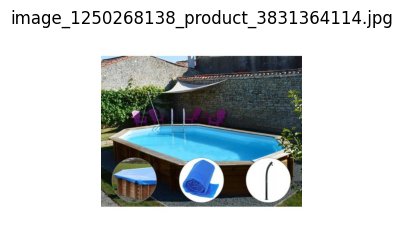

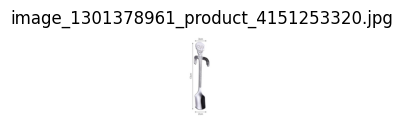

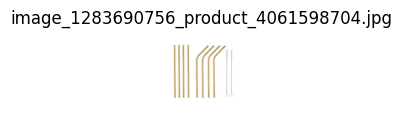

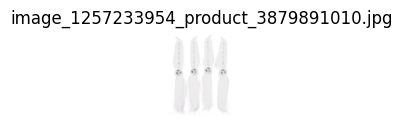

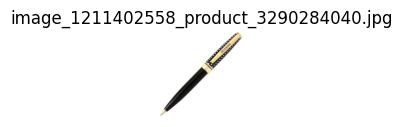

In [ ]:
plt.figure(figsize=(15, 5))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(extract_sous_dossier, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")
    plt.show()



# Exploration type d'images :


In [ ]:
image_shapes = []
for img in image_files:
    image_path = os.path.join(extract_sous_dossier, img)
    image = cv2.imread(image_path)
    if image is not None:
        image_shapes.append(image.shape)


shape_counts = Counter(image_shapes)
print("Distribution des dimensions des images:")
for shape, count in shape_counts.items():
    print(f"Dimension {shape}: {count} images")

Distribution des dimensions des images:
Dimension (500, 500, 3): 999 images


# conclusions :

Taille uniforme : L'analyse de la distribution des dimensions des images montre qu’elles ont toutes la même taille (500x500 pixels). Cela est un bon point pour l'entraînement du classificateur, car cela évite d'avoir à redimensionner les images.




In [ ]:
folder="/content/drive/MyDrive/extrait/images"

Shape du tableau : (999, 2)


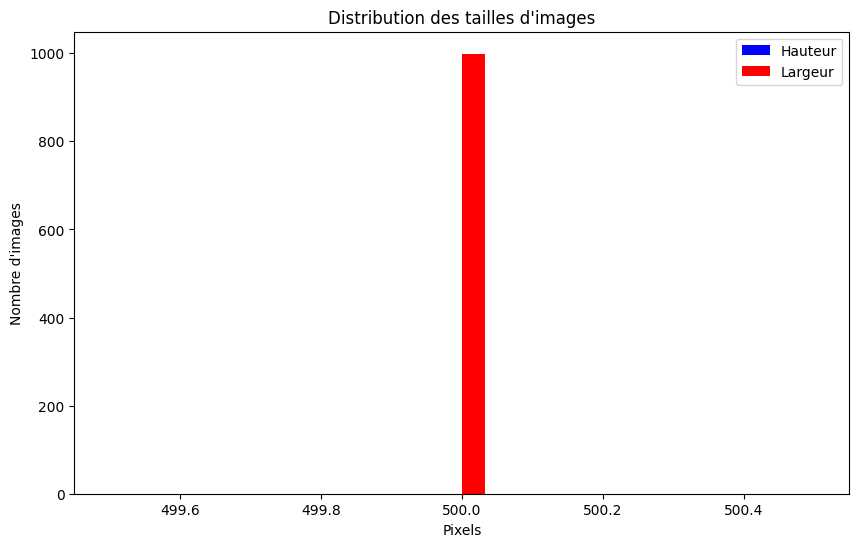

In [ ]:
import seaborn as sns

import numpy as np

dimensions = []
for class_name in os.listdir(folder):
    class_path = os.path.join(folder, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                dimensions.append(image.shape[:2])




if len(dimensions) > 0:
    dimensions = np.array(dimensions)
    if dimensions.ndim == 1:
        dimensions = np.array([d for d in dimensions if isinstance(d, tuple)])
    print("Shape du tableau :", dimensions.shape)

    plt.figure(figsize=(10, 6))
    plt.hist(dimensions[:, 0], bins=30, color="blue", label="Hauteur")
    plt.hist(dimensions[:, 1], bins=30, color="red", label="Largeur")
    plt.legend()
    plt.title("Distribution des tailles d'images")
    plt.xlabel("Pixels")
    plt.ylabel("Nombre d'images")
    plt.show()
else:
    print("Aucune dimension trouvée, vérifiez les images chargées.")

<Figure size 1200x1000 with 0 Axes>

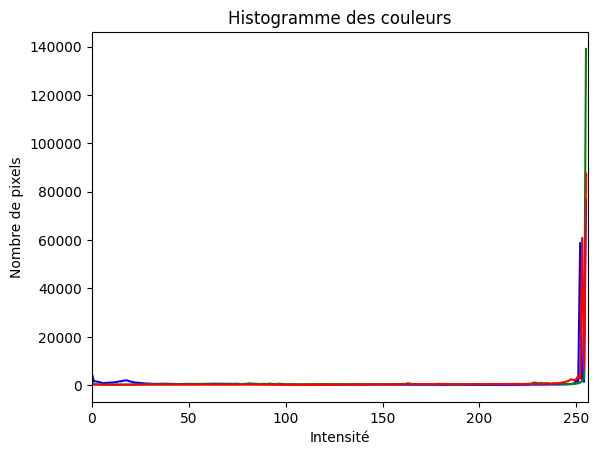

image_992281612_product_299788940.jpg


<Figure size 1200x1000 with 0 Axes>

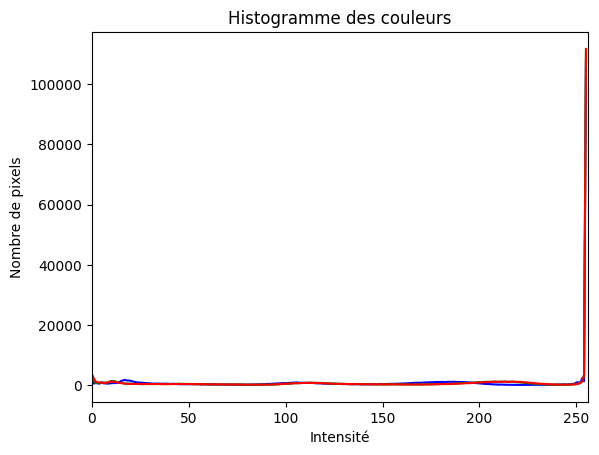

image_1317006847_product_4211512375.jpg


<Figure size 1200x1000 with 0 Axes>

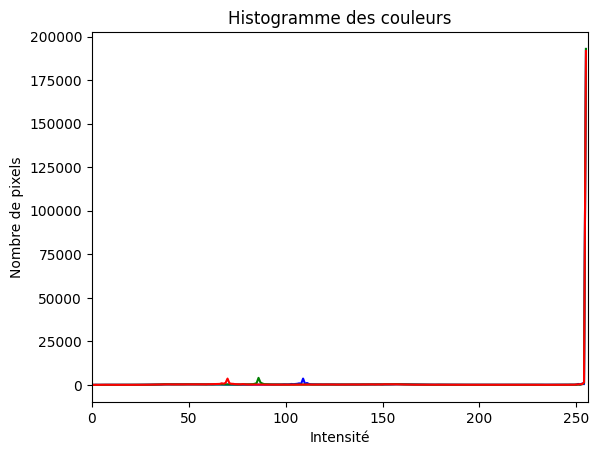

image_1099123319_product_1668783355.jpg


<Figure size 1200x1000 with 0 Axes>

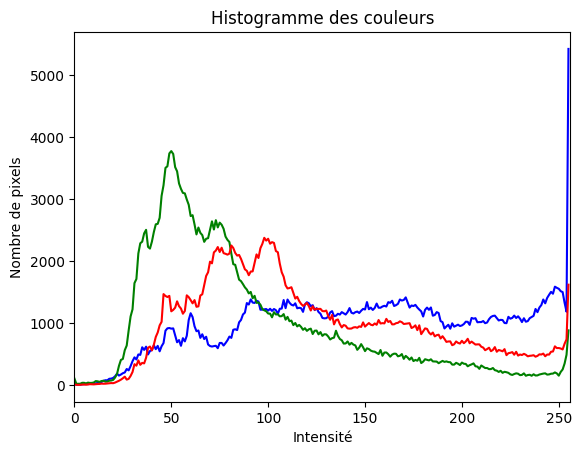

image_1261721272_product_3900896361.jpg


<Figure size 1200x1000 with 0 Axes>

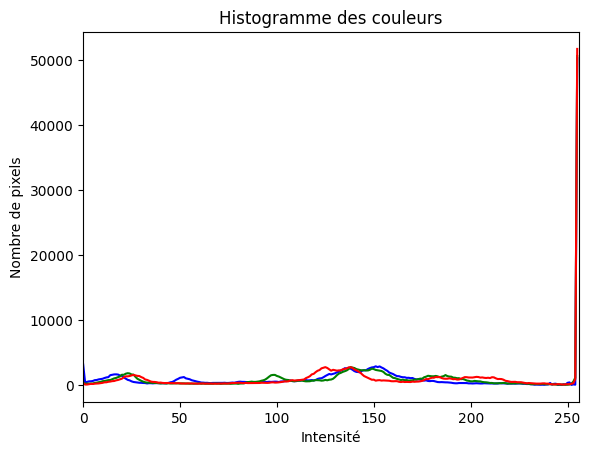

image_1215141011_product_3463091146.jpg


In [ ]:

def plot_color_histogram(image_path):
    image = cv2.imread(image_path)
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    plt.figure(figsize=(12,10))
    plt.figure()
    plt.title("Histogramme des couleurs")
    plt.xlabel("Intensité")
    plt.ylabel("Nombre de pixels")

    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.xlim([0, 256])
    plt.show()


random_image = random.sample(image_files,5)

for image in random_image:
  plot_color_histogram(os.path.join(extract_sous_dossier, image))
  print(image)

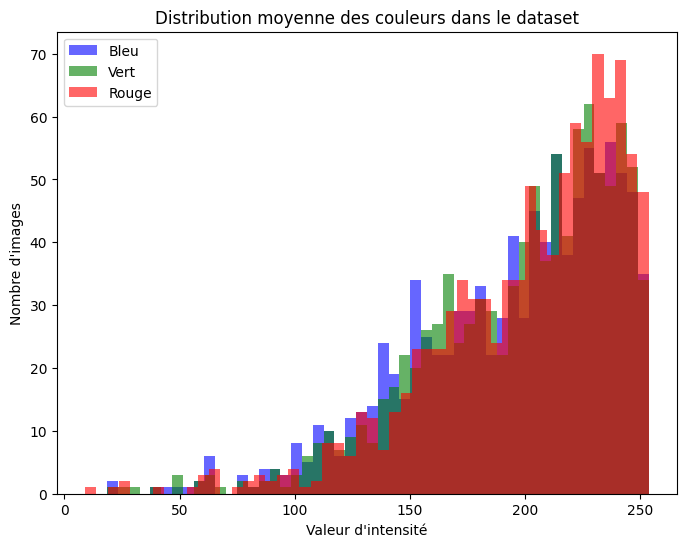

In [ ]:
avg_colors = []
for img in image_files:
    image_path = os.path.join(extract_sous_dossier, img)
    image = cv2.imread(image_path)
    if image is not None:
        avg_colors.append(np.mean(image, axis=(0, 1)))

avg_colors = np.array(avg_colors)


plt.figure(figsize=(8, 6))
plt.hist(avg_colors[:, 0], bins=50, color='blue', alpha=0.6, label='Bleu')
plt.hist(avg_colors[:, 1], bins=50, color='green', alpha=0.6, label='Vert')
plt.hist(avg_colors[:, 2], bins=50, color='red', alpha=0.6, label='Rouge')
plt.title("Distribution moyenne des couleurs dans le dataset")
plt.xlabel("Valeur d'intensité")
plt.ylabel("Nombre d'images")
plt.legend()
plt.show()

##la couleur prédominante du dataset est le rouge

In [ ]:
import hashlib

def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

hashes = {}
duplicates = []
for img in image_files:
    image_path = os.path.join(extract_sous_dossier, img)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        h = dhash(image)
        if h in hashes:
            duplicates.append((img, hashes[h]))
        else:
            hashes[h] = img

print(f"Nombre d'images en double: {len(duplicates)}")
if duplicates:
    print("Exemples de doublons:", duplicates[:5])

Nombre d'images en double: 14
Exemples de doublons: [('image_1063581099_product_1129077347.jpg', 'image_957662880_product_54367779.jpg'), ('image_1196236144_product_3183426616.jpg', 'image_1263434084_product_3712282365.jpg'), ('image_1262471928_product_3900891019.jpg', 'image_973477686_product_269097823.jpg'), ('image_323113730_product_47124938.jpg', 'image_1249535162_product_3819981986.jpg'), ('image_922170120_product_170808071.jpg', 'image_973477686_product_269097823.jpg')]


Il y'a bien des doublons

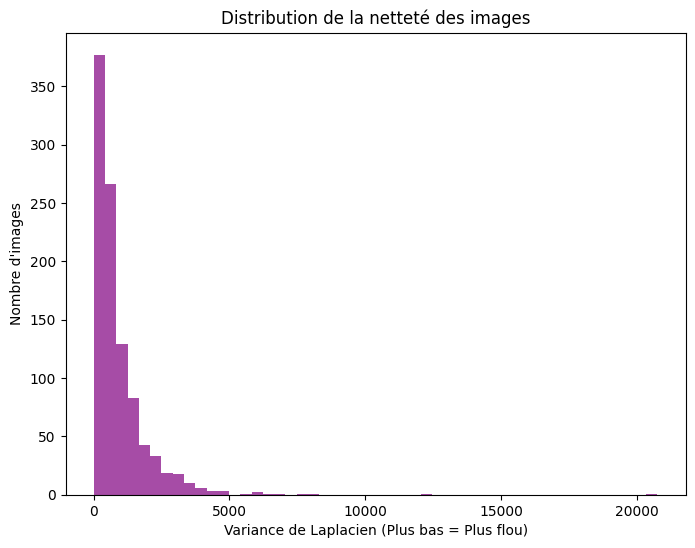

In [ ]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

blur_scores = []
for img in image_files:
    image_path = os.path.join(extract_sous_dossier, img)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        blur_scores.append(variance_of_laplacian(image))

plt.figure(figsize=(8, 6))
plt.hist(blur_scores, bins=50, color='purple', alpha=0.7)
plt.title("Distribution de la netteté des images")
plt.xlabel("Variance de Laplacien (Plus bas = Plus flou)")
plt.ylabel("Nombre d'images")
plt.show()


# Analyse des couleurs des images :

Images en couleur : Toutes les images semblent être en couleur, ce qui signifie que le modèle de classification peut utiliser des informations issues des trois canaux (RVB).

Histogramme des couleurs : L'histogramme des couleurs indique une répartition des pixels en fonction des intensités. On remarque une forte concentration de pixels aux extrêmes (proches de 0 et 255), ce qui peut indiquer des images avec des contrastes marqués ou des fonds uniformes.

Normalisation des pixels : Pour améliorer la convergence du modèle, il est recommandé de normaliser les valeurs des pixels entre 0 et 1.

Couleur dominante : L'histogramme montre que la couleur rouge est majoritaire dans l'ensemble des images.

Répartition des couleurs : Les valeurs de l’intensité augmentent principalement pour les pixels proches de 255, indiquant une forte présence de couleurs claires ou saturées.

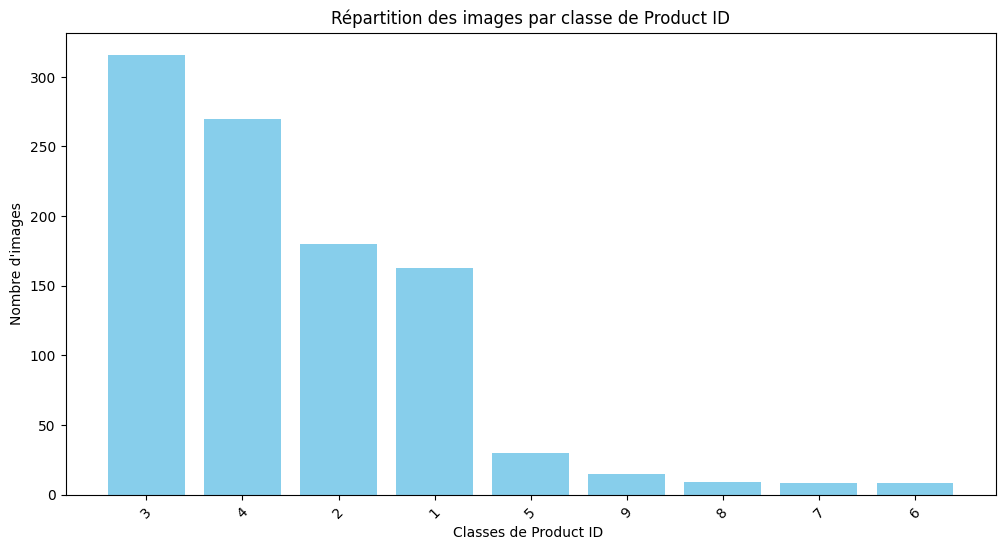

Top classes des Product ID les plus fréquents : {'3': 316, '4': 270, '2': 180, '1': 163, '5': 30, '9': 15, '8': 9, '7': 8, '6': 8}


In [ ]:
product_ids = []
for filename in image_files:
    match = re.search(r"product_(\d+)", filename)
    if match:
        product_ids.append(match.group(1))

# Regrouper les ProductIDs en classes
class_groups = {}
for product_id in product_ids:
    product_class = product_id[:1]
    if product_class in class_groups:
        class_groups[product_class] += 1
    else:
        class_groups[product_class] = 1


sorted_classes = dict(sorted(class_groups.items(), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(12, 6))
plt.bar(sorted_classes.keys(), sorted_classes.values(), color='skyblue')
plt.xlabel("Classes de Product ID ")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe de Product ID")
plt.xticks(rotation=45)
plt.show()

print("Top classes des Product ID les plus fréquents :", sorted_classes)


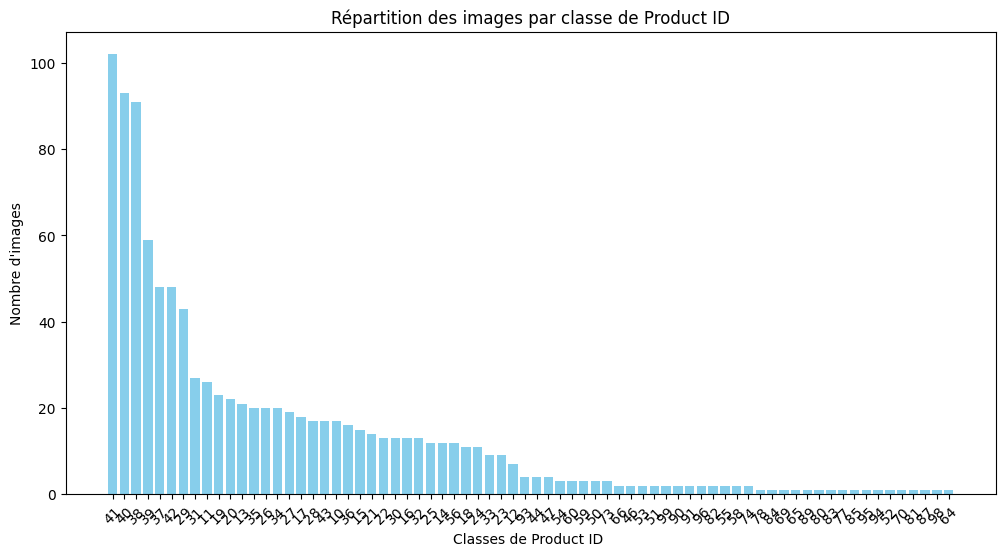

Top classes des Product ID les plus fréquents : {'41': 102, '40': 93, '38': 91, '39': 59, '37': 48, '42': 48, '29': 43, '31': 27, '11': 26, '19': 23, '20': 22, '13': 21, '35': 20, '26': 20, '34': 20, '27': 19, '17': 18, '28': 17, '43': 17, '10': 17, '36': 16, '15': 15, '21': 14, '22': 13, '30': 13, '16': 13, '32': 13, '25': 12, '14': 12, '56': 12, '18': 11, '24': 11, '33': 9, '23': 9, '12': 7, '93': 4, '44': 4, '47': 4, '54': 3, '60': 3, '59': 3, '50': 3, '73': 3, '66': 2, '46': 2, '53': 2, '51': 2, '99': 2, '90': 2, '91': 2, '96': 2, '82': 2, '55': 2, '58': 2, '74': 2, '78': 1, '84': 1, '69': 1, '65': 1, '89': 1, '80': 1, '83': 1, '77': 1, '85': 1, '95': 1, '94': 1, '52': 1, '70': 1, '81': 1, '87': 1, '98': 1, '64': 1}


In [ ]:

product_ids = []
for filename in image_files:
    match = re.search(r"product_(\d+)", filename)
    if match:
        product_ids.append(match.group(1))

# Regrouper les ProductIDs en classes
class_groups = {}
for product_id in product_ids:
    product_class = product_id[:2]
    if product_class in class_groups:
        class_groups[product_class] += 1
    else:
        class_groups[product_class] = 1


sorted_classes = dict(sorted(class_groups.items(), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(12, 6))
plt.bar(sorted_classes.keys(), sorted_classes.values(), color='skyblue')
plt.xlabel("Classes de Product ID ")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe de Product ID")
plt.xticks(rotation=45)
plt.show()

print("Top classes des Product ID les plus fréquents :", sorted_classes)

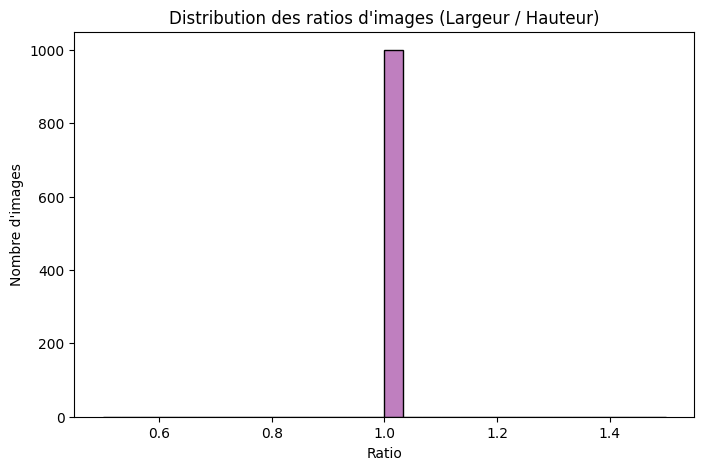

In [ ]:

ratios = dimensions[:, 1] / dimensions[:, 0]

plt.figure(figsize=(8, 5))
sns.histplot(ratios, bins=30, kde=True, color="purple")
plt.title("Distribution des ratios d'images (Largeur / Hauteur)")
plt.xlabel("Ratio")
plt.ylabel("Nombre d'images")
plt.show()


In [ ]:
grayscale_count = 0
total_images = 0

for class_name in os.listdir(folder):
    class_path = os.path.join(folder, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                total_images += 1
                if len(image.shape) == 2 or image.shape[2] == 1:
                    grayscale_count += 1

print(f"Nombre d'images en niveaux de gris: {grayscale_count}/{total_images} ({(grayscale_count/total_images)*100:.2f}%)")


Nombre d'images en niveaux de gris: 0/999 (0.00%)


In [ ]:
pip install -U scikit-image


In [ ]:
import skimage
print(skimage.__version__)


0.25.1


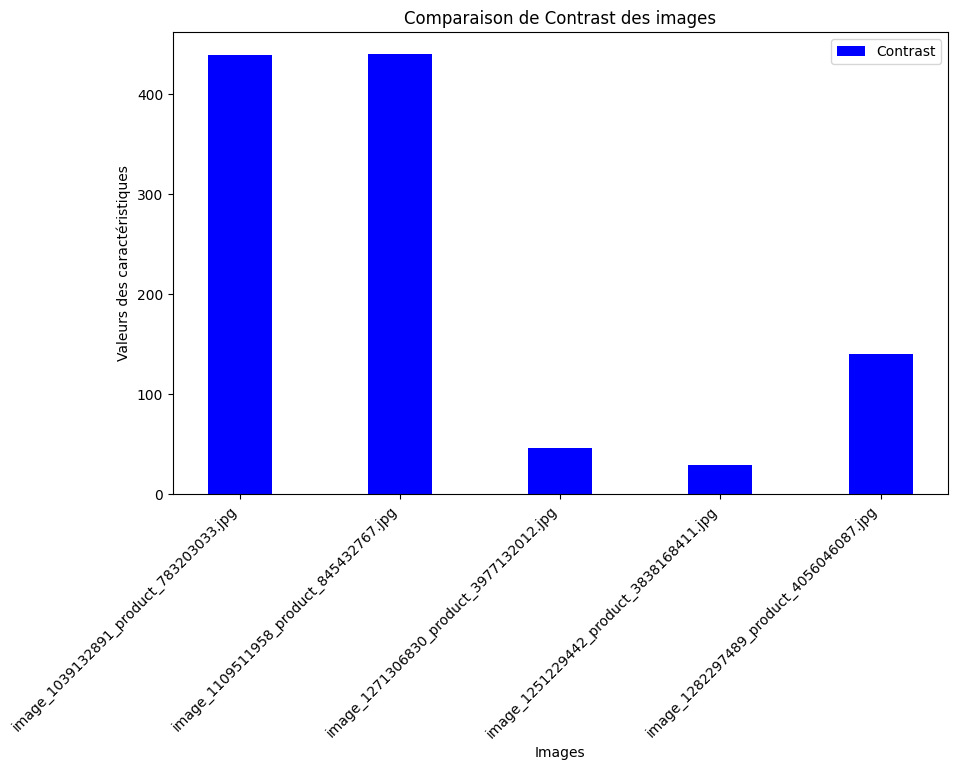

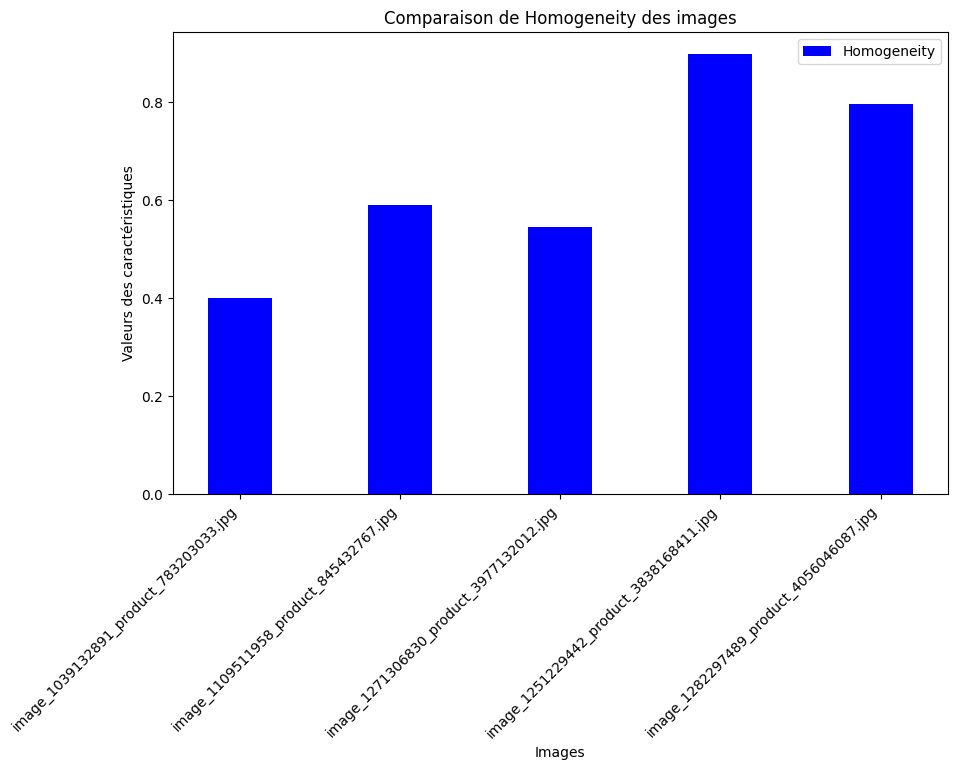

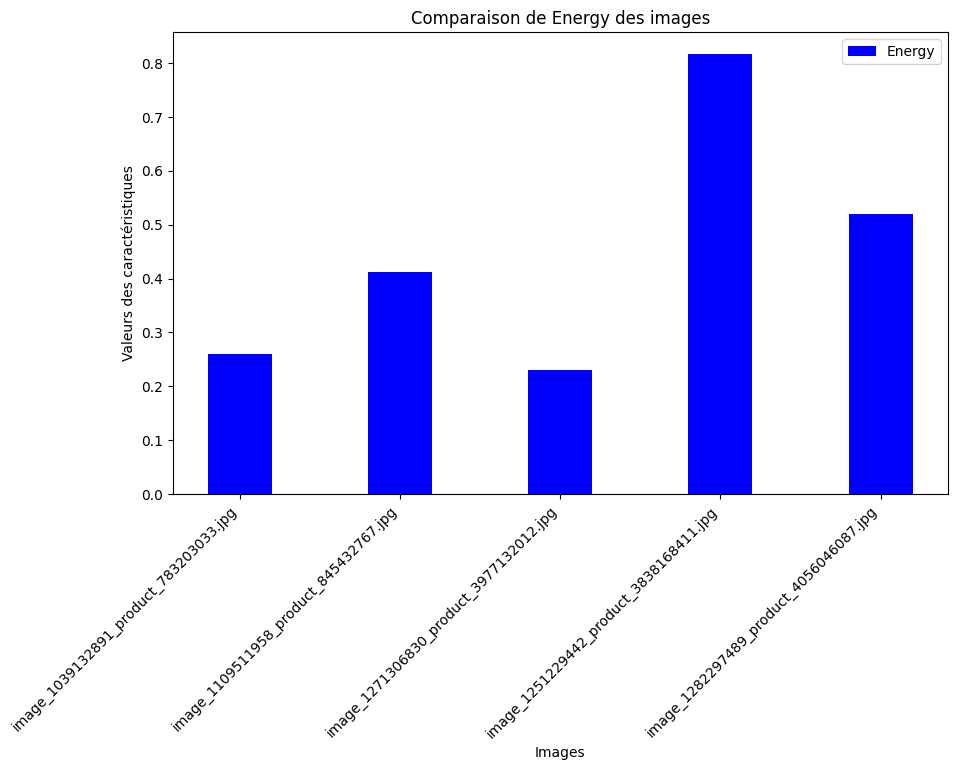

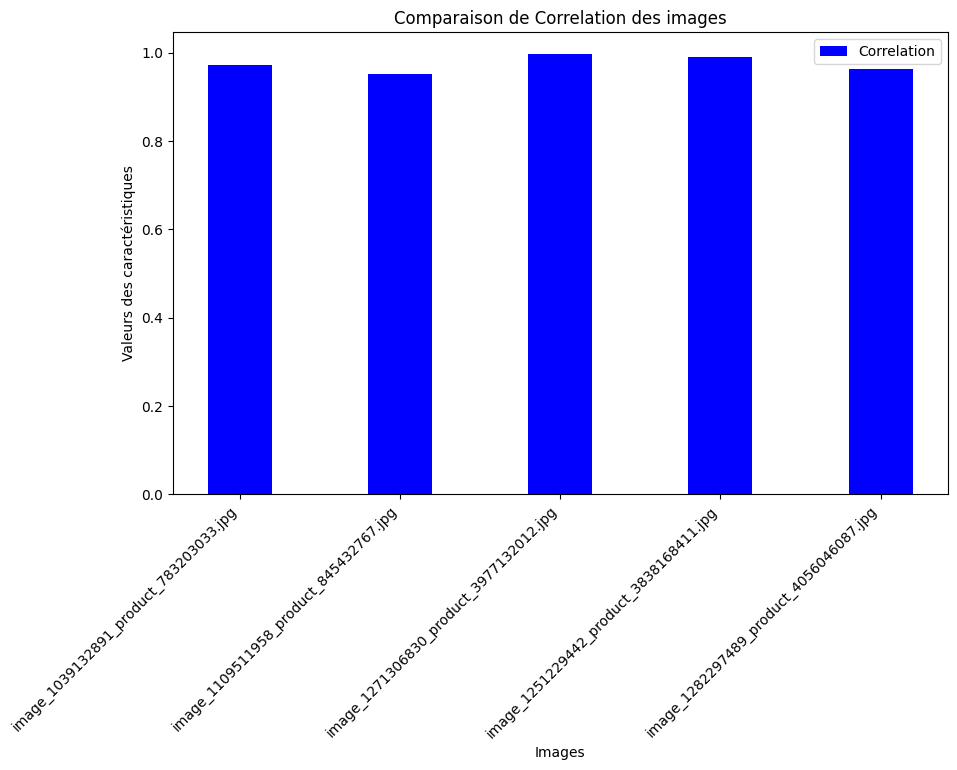

In [ ]:
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return [contrast, homogeneity, energy, correlation]

num_images = min(5, len(image_files))

image_names = []
feature_values = []

for i in range(num_images):
    image_path = os.path.join(extract_sous_dossier, image_files[i])
    image = cv2.imread(image_path)

    if image is not None:
        features = extract_texture_features(image)
        image_names.append(image_files[i])
        feature_values.append(features)


if not feature_values:
    print("Aucune image valide n'a été trouvée.")
else:

    feature_values = np.array(feature_values)
    contrast_values, homogeneity_values, energy_values, correlation_values = feature_values.T


    features = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
    feature_data = [contrast_values, homogeneity_values, energy_values, correlation_values]

    x = np.arange(len(image_names))
    width = 0.4


    for i, feature in enumerate(features):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x, feature_data[i], width, label=feature, color='b')

        ax.set_xlabel("Images")
        ax.set_ylabel("Valeurs des caractéristiques")
        ax.set_title(f"Comparaison de {feature} des images")
        ax.set_xticks(x)
        ax.set_xticklabels(image_names, rotation=45, ha="right")
        ax.legend()

        plt.show()




aucune image en noir et blanc

# Conclusion et recommandations :


Tester la conversion des images en niveaux de gris pour une classification basée uniquement sur la texture et la forme.


Éliminer les doublons pour éviter un biais dans l'entraînement du classificateur.

Vérifier si les doublons sont dus à des variations mineures (ex. changement de luminosité) ou s'ils sont strictement identiques.


Grand nombre d'images floues : L’histogramme de la variance de Laplacien montre qu’une majorité des images a une faible valeur, indiquant un flou élevé.

Impact potentiel : Des images floues peuvent nuire aux performances du modèle de classification.


Supprimer ou corriger les images floues (par filtrage ou augmentation des contrastes).

Tester la robustesse du modèle sur des images nettes vs. floues.


Classes déséquilibrées : Certaines classes contiennent beaucoup plus d'images que d'autres, ce qui peut biaiser l'entraînement du modèle.

Les classes majoritaires : Les ID de produits "3" et "4" ont le plus grand nombre d'images.

Appliquer une stratégie de rééquilibrage, soit en supprimant des images de classes majoritaires, soit en ajoutant des images via l’augmentation de données
